In [15]:
!pip install indic-nlp-library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.2 MB/s eta 0:00:00


In [ ]:
df_train.iloc[0]

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import json
import csv
f=open('/kaggle/input/inlpprojectdata/wiki-cloze/wiki-cloze/hi_sample.json')
data=json.load(f)
f.close()

In [16]:
import pandas as pd
df_train=pd.read_json('/kaggle/input/inlpprojectdata/wiki-section-titles/wiki-section-titles/hi/hi-train.json')
df_test=pd.read_json('/kaggle/input/inlpprojectdata/wiki-section-titles/wiki-section-titles/hi/hi-test.json')
df_val=pd.read_json('/kaggle/input/inlpprojectdata/wiki-section-titles/wiki-section-titles/hi/hi-valid.json')

In [17]:
import matplotlib.pyplot as plt

import torch
from torch import nn,tensor
from torch.utils.data import Dataset,DataLoader
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
import re
import numpy as np
import pandas as pd
import pickle
from indicnlp.tokenize import indic_tokenize
import seaborn as sns

train_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/product_reviews/hi/hi-train.csv'
test_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/product_reviews/hi/hi-test.csv'
val_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/product_reviews/hi/hi-valid.csv'
backward_model_path ='/kaggle/input/inlpprojectdata/pretrained_backward_model'
forward_model_path ='/kaggle/input/inlpprojectdata/pretrained_forward_model'
word_to_ix_path = '/kaggle/input/inlpprojectdata/word_to_ix.pkl'

In [18]:

"""train_df = pd.read_csv(train_path, header=None, names=['Label', 'Text'])

test_df = pd.read_csv(test_path, header=None, names=['Label', 'Text'])
train_df.head()

"""

"train_df = pd.read_csv(train_path, header=None, names=['Label', 'Text'])\n\ntest_df = pd.read_csv(test_path, header=None, names=['Label', 'Text'])\ntrain_df.head()\n\n"

In [19]:
"""from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])
test_df.head()"""


"from sklearn.preprocessing import LabelEncoder\n\nlabel_encoder = LabelEncoder()\ntrain_df['Label'] = label_encoder.fit_transform(train_df['Label'])\ntest_df['Label'] = label_encoder.transform(test_df['Label'])\ntest_df.head()"

In [20]:
df_train.columns

Index(['correctTitle', 'id', 'sectionText', 'titleA', 'titleB', 'titleC',
       'titleD', 'url'],
      dtype='object')

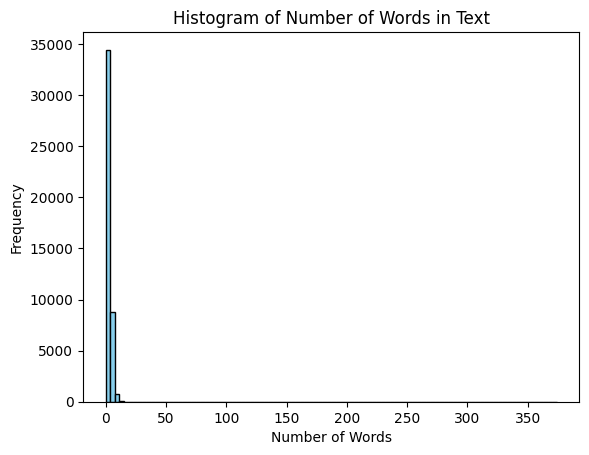

In [21]:

text_word_counts = df_train.titleA.apply(lambda x: len(x.split()))

plt.hist(text_word_counts, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Text')
plt.show()


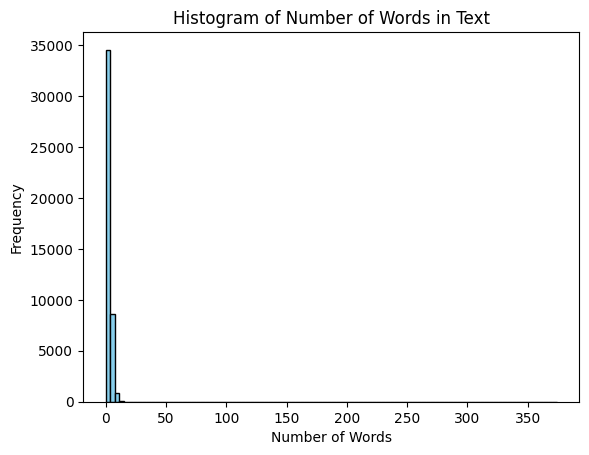

In [22]:

text_word_counts = df_train.titleB.apply(lambda x: len(x.split()))

plt.hist(text_word_counts, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Text')
plt.show()


(array([4.4051e+04, 1.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.  ,  14.96,  29.92,  44.88,  59.84,  74.8 ,  89.76, 104.72,
        119.68, 134.64, 149.6 , 164.56, 179.52, 194.48, 209.44, 224.4 ,
        239.36, 254.32, 269.28, 284.24, 299.2 , 314.16, 329.12, 344.08,
        359.04, 374.  ]),
 <BarContainer object of 25 artists>)

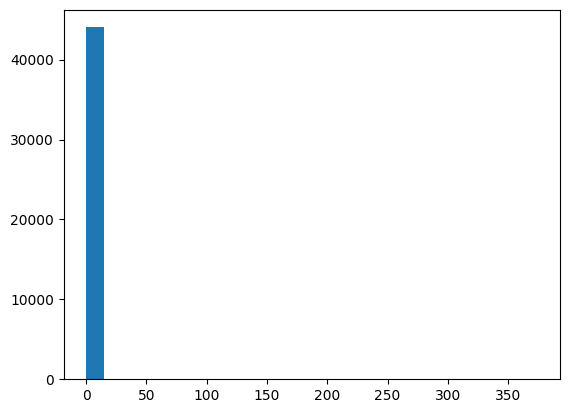

In [23]:
plt.hist(text_word_counts,bins=25)

(array([4.4051e+04, 1.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.  ,  14.96,  29.92,  44.88,  59.84,  74.8 ,  89.76, 104.72,
        119.68, 134.64, 149.6 , 164.56, 179.52, 194.48, 209.44, 224.4 ,
        239.36, 254.32, 269.28, 284.24, 299.2 , 314.16, 329.12, 344.08,
        359.04, 374.  ]),
 <BarContainer object of 25 artists>)

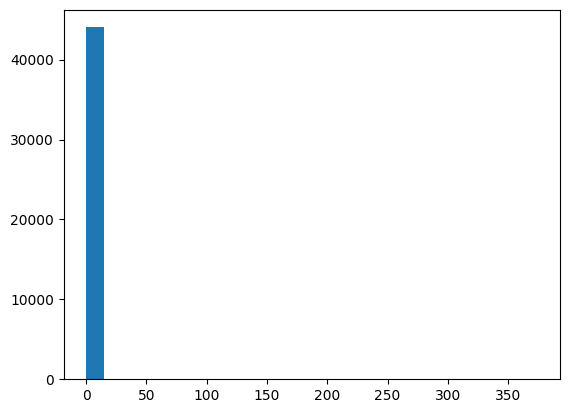

In [24]:
plt.hist(text_word_counts,bins=25)

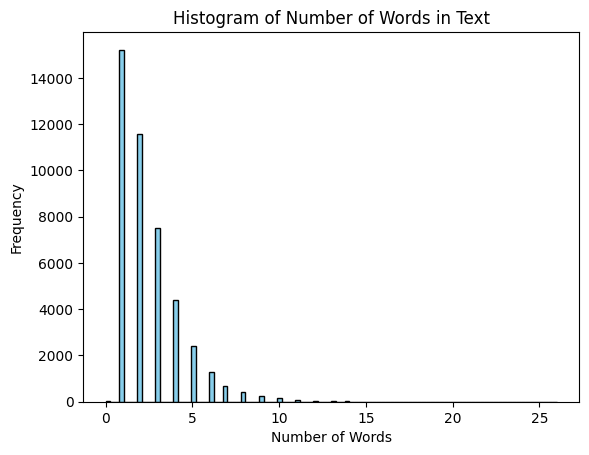

(array([1.5227e+04, 1.1592e+04, 7.5290e+03, 4.4050e+03, 2.4120e+03,
        1.2720e+03, 6.8000e+02, 3.9900e+02, 2.4600e+02, 1.4600e+02,
        6.2000e+01, 4.4000e+01, 2.3000e+01, 1.5000e+01, 9.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.  ,  1.04,  2.08,  3.12,  4.16,  5.2 ,  6.24,  7.28,  8.32,
         9.36, 10.4 , 11.44, 12.48, 13.52, 14.56, 15.6 , 16.64, 17.68,
        18.72, 19.76, 20.8 , 21.84, 22.88, 23.92, 24.96, 26.  ]),
 <BarContainer object of 25 artists>)

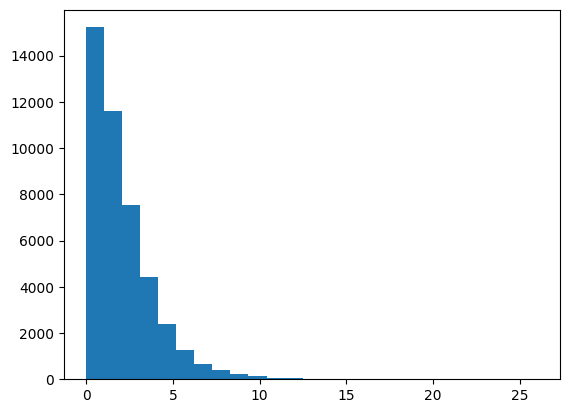

In [25]:

text_word_counts = df_train.titleC.apply(lambda x: len(x.split()))

plt.hist(text_word_counts, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Text')
plt.show()
plt.hist(text_word_counts,bins=25)

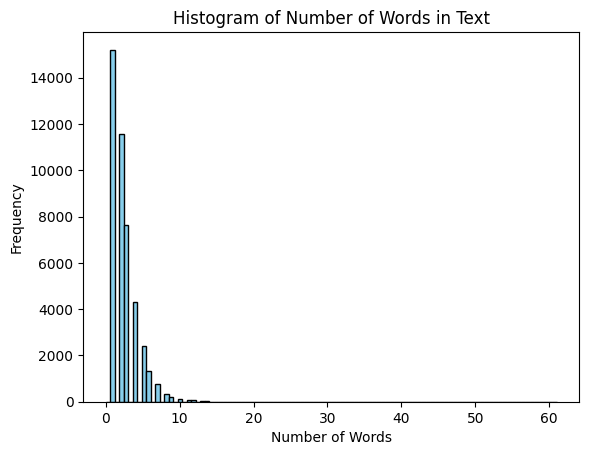

(array([2.6779e+04, 1.1945e+04, 4.4960e+03, 5.6800e+02, 2.1800e+02,
        4.6000e+01, 7.0000e+00, 5.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.  ,  2.44,  4.88,  7.32,  9.76, 12.2 , 14.64, 17.08, 19.52,
        21.96, 24.4 , 26.84, 29.28, 31.72, 34.16, 36.6 , 39.04, 41.48,
        43.92, 46.36, 48.8 , 51.24, 53.68, 56.12, 58.56, 61.  ]),
 <BarContainer object of 25 artists>)

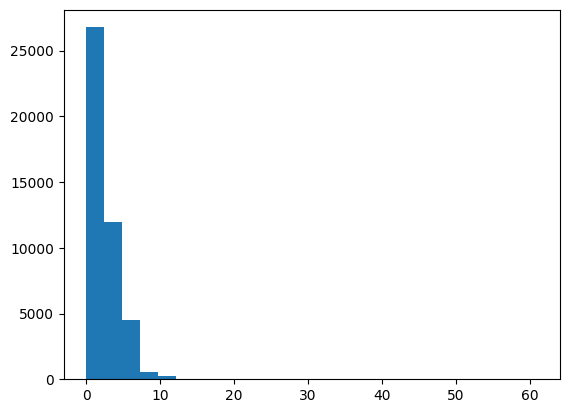

In [26]:

text_word_counts = df_train.titleD.apply(lambda x: len(x.split()))

plt.hist(text_word_counts, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Text')
plt.show()
plt.hist(text_word_counts,bins=25)

Set mxlen as 388

In [27]:
class ElmoProcessor(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,wt_mat):
        super(ElmoProcessor,self).__init__()
        #self.embeddings=nn.Embedding(vocab_size,embedding_dim)
        self.lstmf1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.lstmf2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)
        self.embedding=wt_mat.to(device)
        # self.lstmb1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        # self.lstmb2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)

        self.linear=nn.Linear(hidden_dim,vocab_size)
    def forward(self,embeddingdata):
        emb=torch.tensor(self.embedding(embeddingdata.to(device)))

        emb_f=emb
        # emb_b=emb.flip(1)
        o1f1,h1f1=self.lstmf1(emb_f)
        o2f2,h2f2=self.lstmf2(o1f1)
        # o2f2=o2f2+o1f1
        # h2f2=h2f2+h1f1
        # o1b1,h1b1=self.lstmb1(emb_b)
        # o2b2,h2b2=self.lstmb2(o1b1,h1b1)
        # o2b2=o2b2+o1b1
        # h2b2=h2b2+h1b1

        # weighted_vector_emb=torch.cat([emb_f,emb_b],dim=2)
        # weighted_vector_h1=torch.cat([o1f1,o1f1],dim=2)
        # weighted_vector_h2=torch.cat([o1f1,o2f2],dim=2)
        output =self.linear(o2f2)
        return (output,o1f1,o2f2)

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

wt_mat=torch.zeros(size=(90337,300))
embeddings=torch.tensor(wt_mat,dtype=torch.float)
forward_model= torch.load(forward_model_path,map_location=torch.device('cpu'))
backward_model= torch.load(backward_model_path,map_location=torch.device('cpu'))

/tmp/ipykernel_34/554395451.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings=torch.tensor(wt_mat,dtype=torch.float)


In [29]:
forward_model

ElmoProcessor(
  (lstmf1): LSTM(300, 300, batch_first=True)
  (lstmf2): LSTM(300, 300, batch_first=True)
  (embedding): Embedding(96236, 300, padding_idx=0)
  (linear): Linear(in_features=300, out_features=96236, bias=True)
)

In [30]:
with open(word_to_ix_path, 'rb') as file:

    word_to_ix = pickle.load(file)


In [31]:
len(list(word_to_ix.values()))

96236

In [32]:
list(word_to_ix.keys())[-1]

'कोयो'

In [33]:
df_train.columns

Index(['correctTitle', 'id', 'sectionText', 'titleA', 'titleB', 'titleC',
       'titleD', 'url'],
      dtype='object')

In [34]:
mxlen=[]
for column in df_train[df_train.columns[2]]:
    mxlen.append(len(column))
max(mxlen)

54856

In [35]:
df_train[df_train.columns[0]]

0        titleD
1        titleC
2        titleD
3        titleA
4        titleC
          ...  
44064    titleD
44065    titleB
44066    titleC
44067    titleC
44068    titleB
Name: correctTitle, Length: 44069, dtype: object

In [36]:
len((413-45-1)*[word_to_ix['<PAD>']])

367

In [37]:
df_train.columns

Index(['correctTitle', 'id', 'sectionText', 'titleA', 'titleB', 'titleC',
       'titleD', 'url'],
      dtype='object')

In [38]:
df_train=df_train.reset_index(drop=True)

In [39]:
df_test=df_test.reset_index(drop=True)

In [40]:
class DatafetchClassify(Dataset):
    def __init__(self,split:str):
        sequence=[]
        labels=[]
        options=[]
        for x in tqdm(range(len(split[split.columns[2]])),desc='Generate next word prediction data'):
            #if len(split[split.columns[2]][x])<2 or split[split.columns[2]][x][0]=='=':continue
            data=split[split.columns[2]][x]
           # print(x)
            num=x
            z1=split[split.columns[3]][num]
            z2=split[split.columns[4]][num]
            z3=split[split.columns[5]][num]
            z4=split[split.columns[6]][num]
            a=split[split.columns[0]][num]
            words_data=indic_tokenize.trivial_tokenize(data,'hi')
            context_1=indic_tokenize.trivial_tokenize(z1,'hi')
            context_2=indic_tokenize.trivial_tokenize(z2,'hi')
            context_3=indic_tokenize.trivial_tokenize(z3,'hi')
            context_4=indic_tokenize.trivial_tokenize(z4,'hi')
            indices_words=[word_to_ix.get(i,1) for i in words_data[:360]]
            indices_option_1=[word_to_ix.get(i,1) for i in context_1[:15]]
            indices_option_2=[word_to_ix.get(i,1) for i in context_2[:15]]
            indices_option_3=[word_to_ix.get(i,1) for i in context_3[:10]]
            indices_option_4=[word_to_ix.get(i,1) for i in context_4[:10]]
            #print(z)
            indices_correct=word_to_ix.get(a,1)
            #sequence.append(indices_words+indices_option[0]+(100-len(indices_words)-len(indices_labels))*[word_to_ix['<PAD>']])
            lst=indices_words+indices_option_1+indices_option_2+indices_option_3+indices_option_4+(410-len(indices_words)-len(indices_option_1)-len(indices_option_2)-len(indices_option_3)-len(indices_option_4))*[word_to_ix['<PAD>']] 
            sequence.append(lst)
            #sequence.append(lst)
            #options.append(indices_option)
            #lst_i=[indices_correct for i in range(4)]
            ans=0
            if a=='titleD':
                ans=3
            elif a=='titleC':
                ans=2
            elif a=='titleA':
                ans=1
            else:
                ans=0
            labels.append(ans)
             # alternative: x.strip().split(' ')
        self.labels=tensor(labels)
        self.sequence=tensor(sequence)
        #print(self.labels.unsqueeze(0).t().shape,self.sequence.shape)
        #self.sequence=torch.cat([self.sequence,self.labels.unsqueeze(0).t()],dim=1)
        #self.sequence.to(device)
        #self.labels=tensor(labels)
        #self.labels.to(device)
    def __len__(self)->int:
        return len(self.sequence)
    def __getitem__(self,index:int):
        return self.sequence[index],self.labels[index]

In [26]:
classifier_dataset=DatafetchClassify(df_train)

Generate next word prediction data: 100%|██████████| 44069/44069 [00:26<00:00, 1634.25it/s]


In [27]:
'asdasd'

'asdasd'

In [28]:
word_to_ix['<PAD>']

0

In [29]:
batch_size=32

In [30]:
classifer_dataloader=DataLoader(classifier_dataset,batch_size,shuffle=True,pin_memory=False)
data,labels=next(iter(classifer_dataloader))


In [41]:
class ElmoClassifier(torch.nn.Module):
    def __init__(self,no_classes,forward_model,backward_model,embedding_dim):
        super(ElmoClassifier,self).__init__()
        self.forward_model=forward_model
        self.embedding = forward_model.embedding
        self.backward_model=backward_model
        self.forward_model.requires_grad=False
        self.backward_model.requires_grad=False
        self.linear1=nn.Linear(100,no_classes)
        #self.linear2=nn.Linear(50,no_classes)
        self.leakyrelu=nn.LeakyReLU()
        self.param0=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param1=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param2=nn.Parameter(torch.rand(1),requires_grad=True)
        self.bilstm=nn.LSTM(input_size=embedding_dim*2,hidden_size=50,bidirectional=True,batch_first=True)
    def forward(self,embdata):
        _,o1f1,o2f2=self.forward_model(embdata)
        _,o1b1,o2b2=self.backward_model(embdata)
        # print(embdata.shape)
        # print('\n',o1f1.shape)
        embdata = self.embedding(embdata)
        e = torch.cat([embdata, embdata],dim=2)
        h1=torch.cat([o1f1,o1b1.flip(1)],dim=2)
        h2=torch.cat([o2f2,o2b2.flip(1)],dim=2)
        bio,bih=self.bilstm(self.param0*e + self.param1*h1 +self.param2*h2)
        #print(bio[:,-1,:])
        y=self.linear1(self.leakyrelu(bio[:,-1,:]))
        #y=self.linear2(y)
        return y

In [42]:
len([word_to_ix.keys()])

1

In [43]:
classifier=ElmoClassifier(4,forward_model,backward_model,300)

In [44]:
classifier.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(classifier.parameters(),5e-3)

In [45]:
#del classifier,loss_fn,optimizer,x_train,y_train
import gc
torch.cuda.empty_cache()
gc.collect()

18619

In [46]:
#del classifier,optimizer,x_train,y_train,classifer_dataloader

In [37]:
for epoch in range(5):
    train_loss=0
    classifier.train()
    for batch in tqdm(classifer_dataloader,desc="Training"):
        x_train,y_train=batch
        optimizer.zero_grad()
        x_train.to(device)
        y_train.to(device)
        output=classifier(x_train.to(device))
        loss=loss_fn(output.to(device),y_train.to(device))
        del output
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    print(train_loss)

Training:   0%|          | 0/1378 [00:00<?, ?it/s]/tmp/ipykernel_879/1007020132.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Training: 100%|██████████| 1378/1378 [08:03<00:00,  2.85it/s]


1918.5318051576614


Training: 100%|██████████| 1378/1378 [08:02<00:00,  2.85it/s]


1917.4052200317383


Training: 100%|██████████| 1378/1378 [08:02<00:00,  2.85it/s]


1917.6709475517273


Training: 100%|██████████| 1378/1378 [08:02<00:00,  2.85it/s]


1915.264872431755


Training: 100%|██████████| 1378/1378 [08:02<00:00,  2.85it/s]

1914.2889385223389


In [47]:
classifier_eval=DatafetchClassify(df_test)

Generate next word prediction data: 100%|██████████| 5509/5509 [00:03<00:00, 1780.33it/s]


In [48]:
classifer_dataloader_eval=DataLoader(classifier_eval,batch_size=32,shuffle=False)
data,labels=next(iter(classifer_dataloader_eval))


In [50]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix=np.zeros((4,4))
y_true=[]
y_pred=[]
train_loss=0.0
classifier.eval()
with torch.no_grad():
    for batch in tqdm(classifer_dataloader_eval,desc="Evaluation"):
        x_train,y_train=batch
        #optimizer.zero_grad()
        x_train.to(device)
        y_train.to(device)
        output=classifier(x_train.to(device))
        #print(output.shape)
        _,preds=torch.max(output,dim=1)
        #print(preds,y_train)
        #break
        y_true.extend(y_train.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        for i in range(len(y_train)):
            confusion_matrix[y_train[i]][preds[i]]+=1

Evaluation:   0%|          | 0/173 [00:00<?, ?it/s]/tmp/ipykernel_34/1007020132.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Evaluation: 100%|██████████| 173/173 [00:48<00:00,  3.58it/s]


In [41]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.24      1.00      0.39      1338
           1       0.00      0.00      0.00      1402
           2       0.00      0.00      0.00      1376
           3       0.00      0.00      0.00      1393

    accuracy                           0.24      5509
   macro avg       0.06      0.25      0.10      5509
weighted avg       0.06      0.24      0.09      5509



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

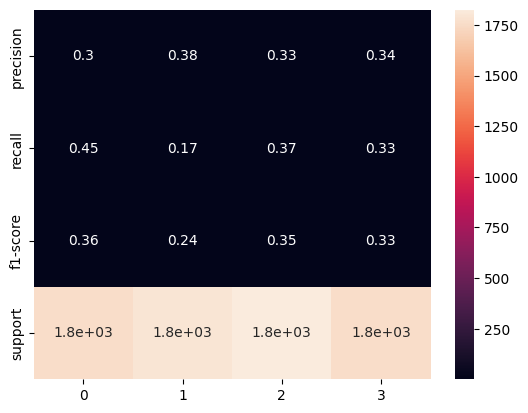

In [14]:
import seaborn as sns 
sns.heatmap(df.iloc[:-2,:].T,annot=True)

<Axes: >

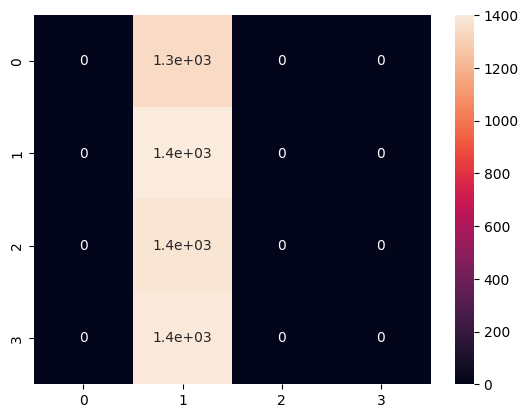

In [51]:
sns.heatmap(confusion_matrix,annot=True)

In [ ]:
accuracy_score(y_true,y_pred)

In [ ]:
torch.save(classifier,'./clozeqanda_final')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#predicted_classes = label_encoder.inverse_transform(y_pred)
#true_classes = label_encoder.inverse_transform(y_true)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

target_names = label_encoder.classes_
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# print(md5)

In [ ]:
# print(classifier)